# Descripción general

A lo largo de este trabajo se compararán distintos modelos, ya establecidos, contra una nueva propuesta de arquitectura usando Few-shot y ViT.

Los modelos a analizar serán:
- **AlexNet** Primera CNN profunda en visión computacional.  
- **DenseNet** Conexiones densas mejoran gradientes y eficiencia.  
- **EfficientNet** Mejor rendimiento con menos parámetros.  
- **ResNet** Introdujo conexiones residuales, resolviendo problemas de entrenamiento en redes profundas.  
- **VGG** Arquitectura simple pero pesada, usada en transferencia de estilo.  
- **ViT** Primer modelo basado en Transformers, rival de las CNNs en clasificación de imágenes.
- **YOLO** Introdujo la detección y clasificación en un solo paso.

Se utilizarán las implementaciones y modelos preentrenados de [PyTorch](https://pytorch.org/vision/main/models.html#classification); a excepción de YOLO, cuya implementación se encuentra en la biblioteca de [Ultralytics](https://docs.ultralytics.com/tasks/classify/) y se mostrará en un archivo separado. En todos los casos, los modelos preentrenados publicados fueron entrenados en ImageNet, por lo que ese se mantendrá como el conjunto de referencia.

A continuación se dará un breviario de cada una, y se añadirá su implementación base para la clasificación de una misma imagen de un minibus.

---

## Código compartido

Dado que en esta libreta se utilizarán modelos que comparten características empezaremos importando las bibliotecas necesarías y definiendo nuestras funciones auxiliares

In [19]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import requests
import os

os.environ['TORCH_HOME'] = '../models/cnn'

# Definir la ruta local donde se guardará la imagen si se descarga
IMAGE_PATH = "bus.jpg"
IMAGE_URL = "https://ultralytics.com/images/bus.jpg"

def load_image(local_path, url):
    """Carga la imagen desde un archivo local o la descarga si no está disponible."""
    if os.path.exists(local_path):
        print(f"📂 Cargando imagen desde {local_path}")
        return Image.open(local_path)
    else:
        print(f"🌐 Descargando imagen desde {url}")
        image = Image.open(requests.get(url, stream=True).raw)
        image.save(local_path)  # Guardar para futuras ejecuciones
        return image
    
# Cargar la imagen una sola vez para todos los modelos
image = load_image(IMAGE_PATH, IMAGE_URL)

def predict(model, image_tensor, labels):
    """Realiza una predicción con un modelo de clasificación de PyTorch."""
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        top_class = torch.argmax(probabilities).item()
    return labels[top_class]

def show_prediction(image, predicted_class, ground_truth):
    """Muestra la imagen con la predicción y verifica si es correcta."""
    plt.imshow(image)
    plt.title(f'Predicción: {predicted_class}')
    plt.axis('off')
    plt.show()

    if predicted_class == ground_truth:
        print("✅ Predicción correcta!")
    else:
        print(f"❌ Predicción incorrecta. Se esperaba: {ground_truth}")


📂 Cargando imagen desde bus.jpg


---

## AlexNet (2012)

- Primer gran avance de *Deep Learning* en clasificación de imágenes, ganador de *ImageNet Challenge 2012*.  
- Introdujo **redes neuronales convolucionales profundas** al mainstream.  

**Características clave:**  
- Arquitectura con **5 capas convolucionales** y **3 capas completamente conectadas**.  
- Usa **ReLU** en lugar de funciones de activación sigmoide/tanh (acelera entrenamiento).  
- Implementa **Dropout** para reducir *overfitting*.  

**Impacto:**  
Marcó el comienzo de la era moderna del *Deep Learning* en visión computacional.  

La descripción original proviene del artículo [ImageNet Classification with Deep Convolutional Neural Networks paper](https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html), mientras que Pytorch implementa una versión ligeramente modificada por la revisión propuesta en [One weird trick for parallelizing convolutional neural network](https://arxiv.org/abs/1404.5997).

**Pesos:**
- PyTorch ofrece una única versión para precargar los pesos [IMAGENET1K_V1](https://pytorch.org/vision/main/models/generated/torchvision.models.alexnet.html#torchvision.models.alexnet)
---

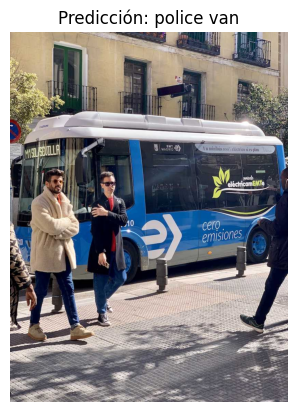

❌ Predicción incorrecta. Se esperaba: minibus


In [20]:
from torchvision.models import alexnet, AlexNet_Weights

# Cargar modelo y transformaciones 
weights = AlexNet_Weights.IMAGENET1K_V1
model_alexnet = alexnet(weights=weights)
transform = weights.transforms()

# Preprocesar imagen
image_tensor = transform(image).unsqueeze(0)  # Convertir a batch de tamaño 1

# Hacer predicción
predicted_class = predict(model_alexnet, image_tensor, weights.meta["categories"])

# Mostrar resultado
show_prediction(image, predicted_class, "minibus")


## DenseNet (2017)

- Basado en conexiones densas entre capas (**Dense Connectivity**).  
- Cada capa recibe **como entrada todas las salidas previas**  **mejor flujo de gradiente**.  

**Características clave:** 
- No se pierden características en capas profundas, evitando el *vanishing gradient*.  
- Usa menos parámetros que ResNet con similar o mejor rendimiento.  

**Impacto:**  
Reduce redundancia en cálculos y mejora el aprendizaje con menos parámetros.  

La implementación de PyTorch esta basada en el artículo [Densely Connected Convolutional Networks](https://arxiv.org/abs/1608.06993).

**Pesos:**

PyTorch ofrece 4 modelos con pesos [IMAGENET1K_V1](https://pytorch.org/vision/main/models/densenet):

- densenet121
- densenet161
- densenet169
- densenet201

---

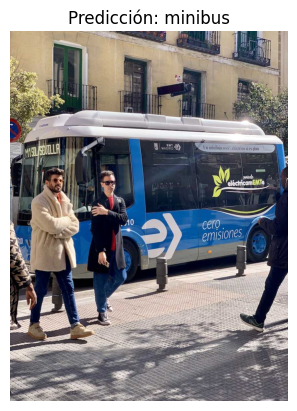

✅ Predicción correcta!


In [21]:
from torchvision.models import densenet121, DenseNet121_Weights

# Cargar modelo y transformaciones oficiales
weights = DenseNet121_Weights.IMAGENET1K_V1
model = densenet121(weights=weights)
transform = weights.transforms()

# Preprocesar imagen
image_tensor = transform(image).unsqueeze(0)  # Convertir a batch de tamaño 1

# Hacer predicción
predicted_class = predict(model, image_tensor, weights.meta["categories"])

# Mostrar resultado
show_prediction(image, predicted_class, "minibus")

## EfficientNet (2019)

EfficientNet es una familia de redes convolucionales desarrollada por Mingxing Tan y Quoc V. Le. Su principal innovación es el uso de Compound Scaling, un método que optimiza de manera conjunta la resolución de la imagen, la profundidad de la red y el ancho de los canales.

Las versiones originales de EfficientNet (EfficientNet-B0 a EfficientNet-B7) fueron diseñadas utilizando Neural Architecture Search (NAS) y lograron un equilibrio entre precisión y eficiencia computacional, superando modelos previos como ResNet y DenseNet con muchos menos parámetros y FLOPs.

**Principales características**:
- Compound Scaling: Ajusta profundidad, ancho y resolución de manera conjunta en lugar de hacerlo de forma independiente.
- MobileNetV3-based Swish Activation & Squeeze-and-Excitation Blocks para mejorar eficiencia.
- Menor cantidad de parámetros y mayor eficiencia en comparación con modelos previos de la misma precisión.
- Mejor rendimiento en ImageNet con menor uso de recursos computacionales.

EfficientNet-B7 logra 84.4% de precisión en ImageNet con solo 66M de parámetros, mientras que ResNet-152 requiere 60M pero tiene menor precisión.

La implementación de PyTorch esta basada en el artículo [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946).

**Pesos:**

PyTorch ofrece 8 modelos con pesos [IMAGENET1K_V1](https://pytorch.org/vision/main/models/efficientnet.html):

- efficientnet_b0
- efficientnet_b1
- efficientnet_b2
- efficientnet_b3
- efficientnet_b4
- efficientnet_b5
- efficientnet_b6
- efficientnet_b7

---

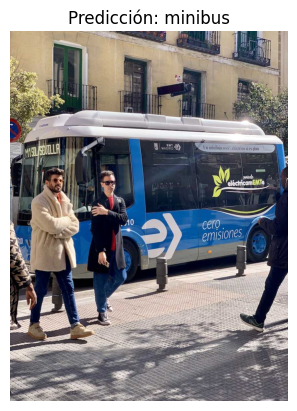

✅ Predicción correcta!


In [22]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Cargar modelo y transformaciones oficiales
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)
transform = weights.transforms()

# Preprocesar imagen
image_tensor = transform(image).unsqueeze(0)  # Convertir a batch de tamaño 1

# Hacer predicción
predicted_class = predict(model, image_tensor, weights.meta["categories"])

# Mostrar resultado
show_prediction(image, predicted_class, "minibus")

## EfficientNetV2 (2021)

EfficientNetV2 es la evolución de EfficientNet, introducida en 2021 por los mismos autores. Esta nueva versión reduce el tamaño del modelo y acelera el entrenamiento, optimizando aún más el rendimiento.

Principales mejoras sobre EfficientNet:

- Arquitectura optimizada para velocidad: Usa una combinación de Fused-MBConv y operaciones tradicionales para acelerar la inferencia.
- Progresive Learning Strategy: Aumenta progresivamente el tamaño de las imágenes durante el entrenamiento para mejorar la eficiencia sin sacrificar precisión.
- Menos parámetros y entrenamiento más rápido: Hasta 6.8x más pequeño y 11x más rápido que ViT en ImageNet.
- Mejor rendimiento en múltiples datasets: EfficientNetV2 logra 87.3% de precisión en ImageNet, superando a ViT con menos costo computacional.

De acuerdo a sus datos EfficientNetV2-S es 2.5x más rápido que EfficientNet-B0 en entrenamiento, mientras que EfficientNetV2-L supera en precisión a EfficientNet-B7 con menor costo computacional.

La implementación de PyTorch esta basada en el artículo [EfficientNetV2: Smaller Models and Faster Training](https://arxiv.org/abs/2104.00298).

**Pesos:**

PyTorch ofrece 3 modelos con pesos [IMAGENET1K_V1](https://pytorch.org/vision/main/models/efficientnet.html):

- efficientnet_v2_s
- efficientnet_v2_m
- efficientnet_v2_l

---

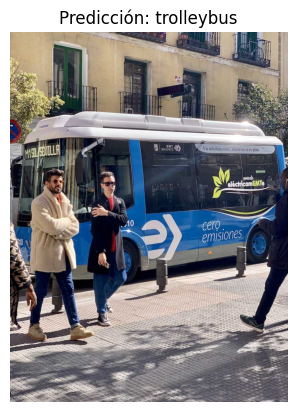

❌ Predicción incorrecta. Se esperaba: minibus


In [23]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

# Cargar modelo y transformaciones oficiales
weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1
model = efficientnet_v2_s(weights=weights)
transform = weights.transforms()

# Preprocesar imagen
image_tensor = transform(image).unsqueeze(0)  # Convertir a batch de tamaño 1

# Hacer predicción
predicted_class = predict(model, image_tensor, weights.meta["categories"])

# Mostrar resultado
show_prediction(image, predicted_class, "minibus")

## ResNet (2015)
  
Introduce **conexiones residuales (skip connections)** para solucionar el problema del *vanishing gradient* en redes profundas.  

**Características clave:**  
- Arquitectura con **bloques residuales** donde \( y = x + F(x) \) (permite entrenar redes muy profundas).  
- Modelos de **ResNet-18, 34, 50, 101, 152**, donde el número indica la cantidad de capas.  
- Redes de más de 100 capas pueden ser entrenadas sin degradación del rendimiento.  

**Impacto:**  
**Fundamental en deep learning moderno**, base para modelos como Mask R-CNN y YOLO.  

La descripción original proviene del artículo [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), mientras que Pytorch implementa una versión ligeramente modificada por la revisión propuesta en [ResNet v1.5 for PyTorch](https://catalog.ngc.nvidia.com/orgs/nvidia/resources/resnet_50_v1_5_for_pytorch), donde el stride=2 se aplica en la convolución 3x3. La reducción de dimensionalidad ocurre en la primera capa 1x1 (sin downsampling), y el downsampling se realiza en la convolución 3x3.

**Pesos:**
PyTorch ofrece 5 versiones para precargar los pesos [IMAGENET1K_V1](https://pytorch.org/vision/main/models/resnet.html).

- resnet18
- resnet34
- resnet50
- resnet101
- resnet152

---

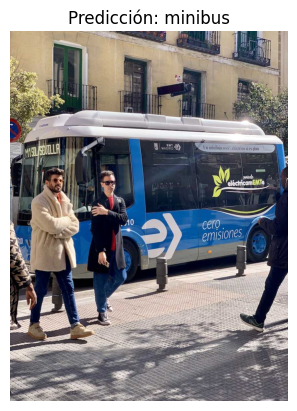

✅ Predicción correcta!


In [24]:
from torchvision.models import resnet18, ResNet18_Weights

# Cargar modelo y transformaciones oficiales
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)
transform = weights.transforms()

# Preprocesar imagen
image_tensor = transform(image).unsqueeze(0)  # Convertir a batch de tamaño 1

# Hacer predicción
predicted_class = predict(model, image_tensor, weights.meta["categories"])

# Mostrar resultado
show_prediction(image, predicted_class, "minibus")

## VGG (2014)
  
- Propone una arquitectura simple pero efectiva basada en **capas convolucionales de 3x3**.  

**Características clave:**  
- Alto número de parámetros (~138M en VGG-16), lo que lo hace pesado.  
- Usa **max-pooling agresivo**, lo que reduce tamaño de la imagen rápidamente.  

**Impacto:**  
**Popular en aplicaciones de transferencia de estilo y redes generativas**, pero reemplazado por modelos más eficientes.  

La implementación de PyTorch esta basada en el artículo [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556).

**Pesos**:
PyTorch ofrece 8 versiones para precargar los pesos [IMAGENET1K_V1](https://pytorch.org/vision/main/models/vgg.html)

- vgg11
- vgg11_bn
- vgg13
- vgg13_bn
- vgg16
- vgg16_bn
- vgg19
- vgg19_bn

---

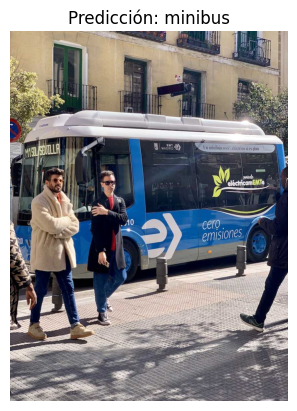

✅ Predicción correcta!


In [25]:
from torchvision.models import vgg11, VGG11_Weights

# Cargar modelo y transformaciones oficiales
weights = VGG11_Weights.IMAGENET1K_V1
model = vgg11(weights=weights)
transform = weights.transforms()

# Preprocesar imagen
image_tensor = transform(image).unsqueeze(0)  # Convertir a batch de tamaño 1

# Hacer predicción
predicted_class = predict(model, image_tensor, weights.meta["categories"])

# Mostrar resultado
show_prediction(image, predicted_class, "minibus")

## Vision Transformer (ViT, 2020)
  
**Primer modelo basado en Transformers para clasificación de imágenes**.  
- Sustituye convoluciones por **mecanismo de autoatención**.  

**Características clave:**  
- Divide la imagen en **patches** (ej. 16x16), los convierte en secuencias y los pasa por *self-attention*.  
- No depende de inductivas espaciales como las CNNs.  
- Modelos ViT-B, ViT-L y ViT-H, donde L y H son más grandes.  

**Impacto:**  
**Rompe la dominancia de las CNNs en visión por computadora**. Su principal desventaja es que requiere grandes cantidades de datos para entrenar.  

La implementación de PyTorch esta basada en el artículo [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929).

**Pesos**:
PyTorch ofrece 8 versiones para precargar los pesos [IMAGENET1K_V1](https://pytorch.org/vision/main/models/vision_transformer.html)

- vit_b_16
- vit_b_32
- vit_l_16
- vit_l_32
- vit_h_14

---

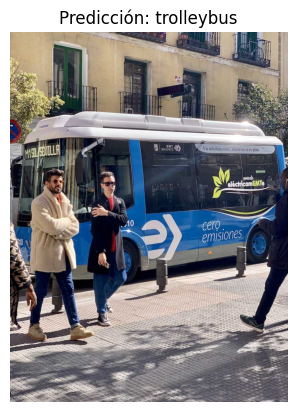

❌ Predicción incorrecta. Se esperaba: minibus


In [26]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Cargar modelo y transformaciones oficiales
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)
transform = weights.transforms()

# Preprocesar imagen
image_tensor = transform(image).unsqueeze(0)  # Convertir a batch de tamaño 1

# Hacer predicción
predicted_class = predict(model, image_tensor, weights.meta["categories"])

# Mostrar resultado
show_prediction(image, predicted_class, "minibus")